# PUBG Finish Placement Prediction

In [2]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import random
random.seed(16)


In [3]:
# Read data to dataframe
df = pd.read_csv("data/train_V2.csv")
df_types = pd.read_csv("data/types.csv")


In [4]:
# Initial settings
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',500)
pd.set_option('display.width',2000)

In [5]:
# Memory saving function credit to https://www.kaggle.com/gemartin/load-data-reduce-memory-usage
def reduce_mem_usage(df):
    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    return df

In [6]:
df = reduce_mem_usage(df)
df_types = reduce_mem_usage(df_types)

In [7]:
# Function to split data into two sets
# Data is grouped by "matchId" which means that games are not mixed up between sets.
def split_into_train_test_sets(df, test_set_size=0.2):
    match_ids = df['matchId'].unique().tolist()
    train_size = int(len(match_ids) * (1 - test_set_size))
    train_match_ids = random.sample(match_ids, train_size)

    train = df[df['matchId'].isin(train_match_ids)]
    test = df[-df['matchId'].isin(train_match_ids)]
    
    return train, test

## Cleaning data

In the data set there is one row of data where the variable we are going to predict is missing. We need to drop it.

In [23]:
df[df.isnull().any(axis=1)]


,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc


In [24]:
df = df[pd.notnull(df['winPlacePerc'])]



Row where winPlacePerc is missing is gone.

To do 
- remove custom games 
- look for some outliers??


## Train data and test data

Source of data: https://www.kaggle.com/c/pubg-finish-placement-prediction

Our data contains around 4.5 millions rows.

We are going to split it into two sets:
- train set,
- test set

In [10]:
df_train, df_test = split_into_train_test_sets(df, 0.2)

### Train data


Brief look at the train data

In [11]:
df_train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00000,0,0,0,60,1241,0,0,0.00000,1306,squad-fpp,28,26,-1,0,0.000000,0,0.000000,0,0,244.75,1,1466,0.444336
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.50000,0,0,0,57,0,0,0,0.00000,1777,squad-fpp,26,25,1484,0,0.004501,0,11.039062,0,0,1434.00,5,0,0.640137
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00000,0,0,0,47,0,0,0,0.00000,1318,duo,50,47,1491,0,0.000000,0,0.000000,0,0,161.75,2,0,0.775391
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90625,0,0,0,75,0,0,0,0.00000,1436,squad-fpp,31,30,1408,0,0.000000,0,0.000000,0,0,202.75,3,0,0.166748
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00000,0,0,0,45,0,1,1,58.53125,1424,solo-fpp,97,95,1560,0,0.000000,0,0.000000,0,0,49.75,2,0,0.187500


In [12]:
df_train.describe()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
count,3.558116e+06,3.558116e+06,3.558116e+06,3.558116e+06,3.558116e+06,3.558116e+06,3.558116e+06,3.558116e+06,3.558116e+06,3.558116e+06,3.558116e+06,3.558116e+06,3.558116e+06,3.558116e+06,3.558116e+06,3.558116e+06,3.558116e+06,3.558116e+06,3558116.0,3.558116e+06,3.558116e+06,3558116.000,3.558116e+06,3.558116e+06,3.558116e+06
mean,2.336056e-01,1.107092e+00,NaN,6.579819e-01,2.267234e-01,1.370554e+00,4.759973e+01,5.024616e+02,9.247785e-01,5.441068e-01,NaN,1.578562e+03,4.452148e+01,4.303113e+01,8.950157e+02,1.645955e-01,NaN,3.542324e-03,NaN,2.379068e-02,7.926386e-03,NaN,3.659158e+00,6.034637e+02,NaN
std,5.878200e-01,1.716144e+00,NaN,1.146979e+00,6.014604e-01,2.680608e+00,2.746161e+01,6.269021e+02,1.556788e+00,7.108294e-01,NaN,2.585187e+02,2.382931e+01,2.329255e+01,7.360840e+02,4.723772e-01,NaN,7.423721e-02,NaN,1.671244e-01,9.272658e-02,NaN,2.451825e+00,7.391010e+02,0.000000e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.330000e+02,2.000000e+00,1.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,0.000,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.400000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.366000e+03,2.800000e+01,2.700000e+01,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,155.125,2.000000e+00,0.000000e+00,1.999512e-01
50%,0.000000e+00,0.000000e+00,8.431250e+01,0.000000e+00,0.000000e+00,0.000000e+00,4.700000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.438000e+03,3.000000e+01,3.000000e+01,1.444000e+03,0.000000e+00,0.000000e+00,0.000000e+00,0.0,0.000000e+00,0.000000e+00,685.000,3.000000e+00,0.000000e+00,4.582520e-01
75%,0.000000e+00,2.000000e+00,1.860000e+02,1.000000e+00,0.000000e+00,2.000000e+00,7.100000e+01,1.169000e+03,1.000000e+00,1.000000e+00,2.131250e+01,1.850000e+03,4.900000e+01,4.700000e+01,1.500000e+03,0.000000e+00,7.232666e-02,0.000000e+00,0.0,0.000000e+00,0.000000e+00,1975.000,5.000000e+00,1.495000e+03,7.407227e-01
max,1.700000e+01,3.300000e+01,6.376000e+03,5.300000e+01,6.400000e+01,7.300000e+01,1.000000e+02,2.156000e+03,7.200000e+01,1.800000e+01,1.094000e+03,2.237000e+03,1.000000e+02,1.000000e+02,5.827000e+03,3.900000e+01,4.070400e+04,1.800000e+01,3824.0,1.200000e+01,5.000000e+00,25776.000,1.770000e+02,2.001000e+03,1.000000e+00


### Test data

In [13]:
df_test.head()


,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,matchType,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
7,311b84c6ff4390,eaba5fcb7fc1ae,292611730ca862,0,0,8.539062,0,0,0,48,1000,0,0,0.000000,1967,solo-fpp,96,92,-1,0,2004.0,0,0.00000,0,0,1089.000,6,1500,0.736816
19,71cbdbc3b263e5,7b61f74b51906c,a329ac99449ad7,0,1,65.250000,0,0,1,48,1349,0,0,0.000000,1322,squad-fpp,30,28,0,0,0.0,0,20.84375,0,0,3310.000,3,1479,0.931152
28,f9473c4f1cfdc4,8483976f3ba230,6057f846f3ed12,0,6,345.500000,2,1,1,6,0,4,1,105.187500,1339,squad-fpp,28,28,1339,0,0.0,0,0.00000,0,0,3856.000,4,0,0.962891
34,e2d4735f01b693,b65eae4ed1dbba,022d1ec646ed21,0,1,440.000000,4,0,1,34,0,1,1,11.359375,1905,squad-fpp,28,26,1518,0,0.0,0,0.00000,0,0,353.500,2,0,0.222168
39,6e55ca8db3570e,1aeaa4d08608e8,7c48a07ae6550e,1,0,177.750000,1,0,0,73,0,0,0,0.000000,1222,squad-fpp,28,27,1448,0,0.0,0,0.00000,0,0,133.375,1,0,0.148071


In [14]:
df_test.describe()

,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,killPoints,kills,killStreaks,longestKill,matchDuration,maxPlace,numGroups,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
count,888849.000000,888849.000000,888849.000,888849.00000,888849.000000,888849.000000,888849.000000,888849.000000,888849.000000,888849.000000,888849.0000,888849.000000,888849.000000,888849.000000,888849.000000,888849.000000,888849.000000,888849.000000,888849.0,888849.000000,888849.000000,888849.00,888849.000000,888849.000000,888849.000000
mean,0.234653,1.106173,NaN,0.65745,0.227205,1.368520,47.597863,515.192260,0.924804,0.543349,NaN,1583.288834,44.437429,42.913437,879.979536,0.164913,NaN,0.003311,NaN,0.024180,0.007885,NaN,3.665816,618.455550,NaN
std,0.591578,1.714393,NaN,1.14078,0.604929,2.677476,27.468220,629.809668,1.565061,0.711543,NaN,259.583873,23.823143,23.277012,738.778355,0.471325,NaN,0.069806,NaN,0.168466,0.092150,NaN,2.475334,741.974746,0.000000
min,0.000000,0.000000,0.000,0.00000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.0000,352.000000,2.000000,1.000000,-1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.00,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000,0.00000,0.000000,0.000000,24.000000,0.000000,0.000000,0.000000,0.0000,1368.000000,28.000000,27.000000,-1.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,155.25,2.000000,0.000000,0.199951
50%,0.000000,0.000000,84.000,0.00000,0.000000,0.000000,47.000000,0.000000,0.000000,0.000000,0.0000,1441.000000,30.000000,30.000000,1440.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,688.00,3.000000,0.000000,0.458252
75%,0.000000,2.000000,186.125,1.00000,0.000000,2.000000,71.000000,1180.000000,1.000000,1.000000,21.3125,1855.000000,49.000000,47.000000,1500.000000,0.000000,5.402344,0.000000,0.0,0.000000,0.000000,1981.00,5.000000,1496.000000,0.740723
max,22.000000,22.000000,6616.000,33.00000,39.000000,80.000000,101.000000,2170.000000,65.000000,20.000000,1081.0000,2200.000000,100.000000,100.000000,5910.000000,19.000000,31376.000000,11.000000,2382.0,5.000000,4.000000,13528.00,236.000000,2013.000000,1.000000


### Data Fields Descriptions


In [15]:
print(df_types)


         Data field                                        Description     Type
0                Id                                        Player's Id   object
1           groupId              ID to identify a group within a match   object
2           matchId                               ID to identify match   object
3         matchType  String identifing the game mode that the data ...   object
4           assists  Number of enemy players this player damaged th...    int64
5            boosts                         Number of boost items used    int64
6       damageDealt                                 Total damage dealt  float64
7             DBNOs                    Number of enemy players knocked    int64
8     headshotKills      Number of enemy players killed with headshots    int64
9             heals                       Number of healing items used    int64
10        killPlace  Ranking in match of number of enemy players ki...    int64
11       killPoints             Kills-ba

We have total 28 predictors where 24 of them is numerical. Id, groupId, matchId and matchType are objects. The three ids identify the players information of each group in each match the participated. The match type indicates one of the 16 game types.

In [16]:
print(df_train["matchType"].unique())

['squad-fpp' 'duo' 'solo-fpp' 'squad' 'duo-fpp' 'solo' 'normal-squad-fpp'
 'crashfpp' 'flaretpp' 'normal-solo-fpp' 'flarefpp' 'normal-duo-fpp'
 'normal-duo' 'crashtpp' 'normal-squad' 'normal-solo']


Players playing solo-match have their own placement, while the players from the same group share the same placement.

## Data analysis and visualization

### Correlation of feature 

A correlation matrix is a table showing correlation coefficients between variables. Each cell in the table shows the correlation between two variables.

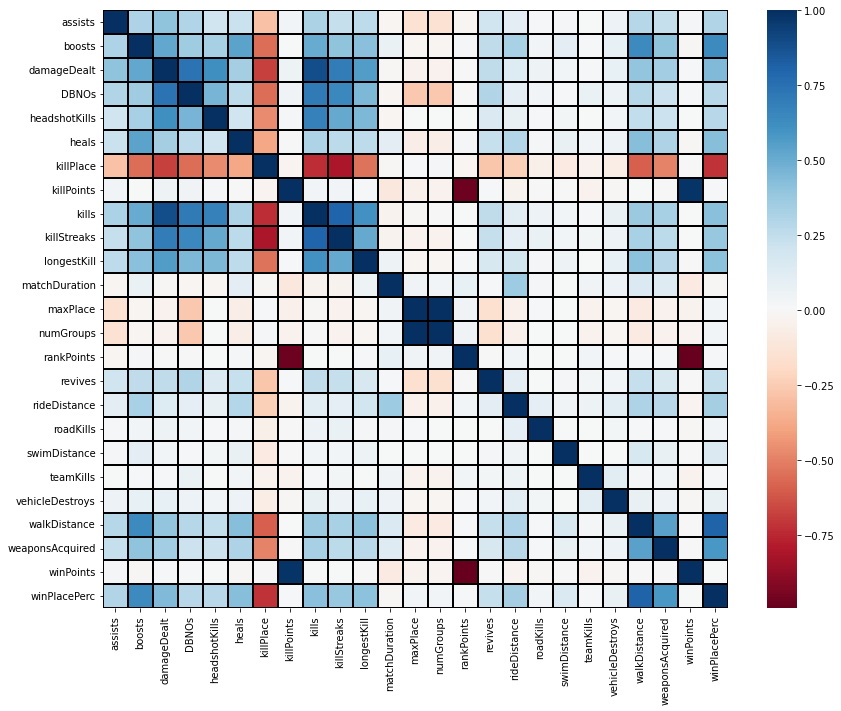

In [31]:
# We do not use columns containing Id and matchType. Only numerical values.
cols_to_drop = ['Id', 'groupId', 'matchId', 'matchType']
cols_to_fit = [col for col in df.columns if col not in cols_to_drop]
corr = df[cols_to_fit].corr()

plt.figure(figsize=(14,11))
sns.heatmap(
    corr,
    xticklabels=corr.columns.values,
    yticklabels=corr.columns.values,
    linecolor='black',
    linewidths=0.1,
    cmap="RdBu"
)
plt.show()

As we can see there are some pairs of value that are highly correlated. It is possible that the highly correlated variables such as might be the most important features in predicting winPlacePerc. 

Pairs with correlation >= 0.45:

In [29]:
corr_pairs = corr.unstack().sort_values(ascending=False).drop_duplicates()

corr_pairs[corr_pairs >= 0.45]

assists          assists            1.000000
maxPlace         numGroups          0.997900
killPoints       winPoints          0.983417
kills            damageDealt        0.888784
walkDistance     winPlacePerc       0.810886
kills            killStreaks        0.802500
DBNOs            damageDealt        0.735762
kills            DBNOs              0.707848
killStreaks      damageDealt        0.703599
kills            headshotKills      0.674275
killStreaks      DBNOs              0.646872
boosts           walkDistance       0.640150
                 winPlacePerc       0.634232
damageDealt      headshotKills      0.613409
kills            longestKill        0.602937
winPlacePerc     weaponsAcquired    0.583806
longestKill      damageDealt        0.563838
weaponsAcquired  walkDistance       0.541222
heals            boosts             0.535854
damageDealt      boosts             0.521947
killStreaks      longestKill        0.515097
                 headshotKills      0.512882
boosts    

### What is more efficient walking or driving?

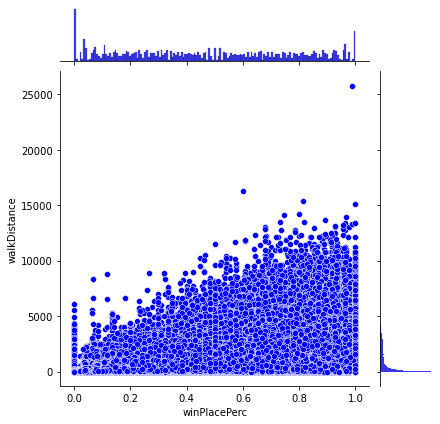

In [18]:
sns.jointplot(x='winPlacePerc', y='walkDistance', data=df, color='blue')


In [ ]:
sns.jointplot(x='winPlacePerc', y='rideDistance', data=df, color='green')

## New Features


To do:
- try some new features and check them
